# Shannon entropy (H), Lempel-Ziv complexity (LZ) and Effort-To-Compress complexity (ETC) with Lyapunov exponent (λ) #

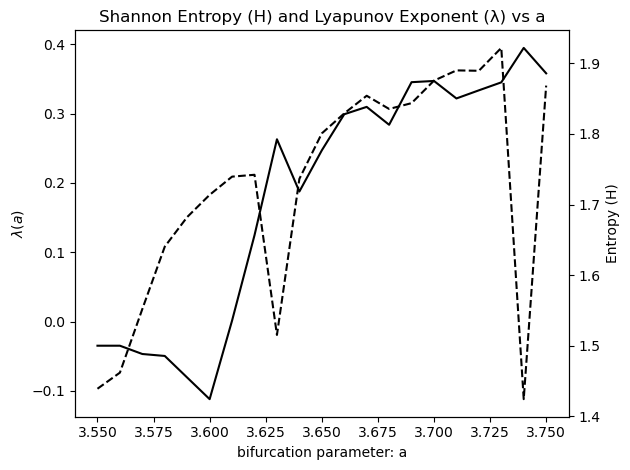

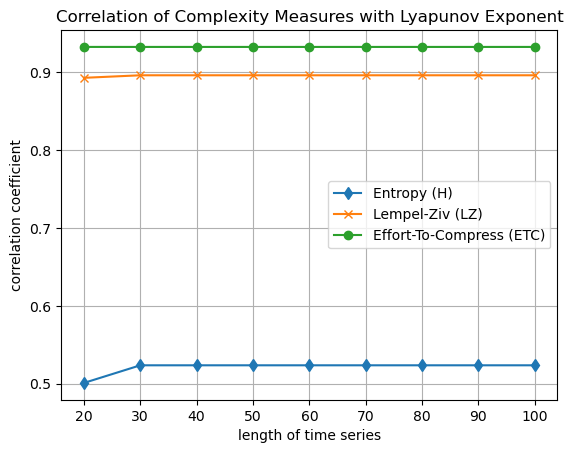

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy as shannon_entropy
from collections import Counter
import math

# Logistic map function
def logistic_map(a, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = a * x[i-1] * (1 - x[i-1])
    return x

# Symbolization with proper binning (use 4 bins as in the paper)
def symbolize(time_series, num_bins=4):
    min_val, max_val = np.min(time_series), np.max(time_series)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    return np.digitize(time_series, bin_edges[1:-1])

# Shannon entropy calculation
def calc_shannon_entropy(symbolic_sequence):
    counts = Counter(symbolic_sequence)
    probs = np.array(list(counts.values())) / len(symbolic_sequence)
    return shannon_entropy(probs, base=2)

# Lempel-Ziv complexity
def lz_complexity(symbolic_sequence):
    sub_strings = set()
    n = len(symbolic_sequence)
    ind = 0
    inc = 1
    while ind + inc <= n:
        sub_str = tuple(symbolic_sequence[ind:ind + inc])
        if sub_str in sub_strings:
            inc += 1
        else:
            sub_strings.add(sub_str)
            ind += inc
            inc = 1
    return len(sub_strings)

def normalized_lz_complexity(symbolic_sequence):
    n = len(symbolic_sequence)
    alpha = len(set(symbolic_sequence))
    if alpha <= 1:
        return 0.0
    c = lz_complexity(symbolic_sequence)
    return (c / n) * math.log(n, alpha)

# Effort-to-Compress complexity with slightly higher max_steps
def etc_complexity(symbolic_sequence, max_steps=40):
    sequence = list(symbolic_sequence)
    step = 0
    while len(set(sequence)) > 1 and len(sequence) > 2:
        pair_counts = Counter(zip(sequence[:-1], sequence[1:]))
        most_frequent_pair, _ = max(pair_counts.items(), key=lambda x: x[1])
        new_symbol = max(sequence) + 1
        
        # Replace non-overlapping pairs
        new_seq = []
        i = 0
        while i < len(sequence) - 1:
            if (sequence[i], sequence[i+1]) == most_frequent_pair:
                new_seq.append(new_symbol)
                i += 2
            else:
                new_seq.append(sequence[i])
                i += 1
        if i == len(sequence) - 1:
            new_seq.append(sequence[-1])
        
        # Check for changes
        if new_seq == sequence or len(new_seq) <= 2:
            break
        sequence = new_seq
        step += 1
        if max_steps and step >= max_steps:
            break
    return step

def normalized_etc_complexity(symbolic_sequence, max_steps=40):
    n = len(symbolic_sequence)
    etc = etc_complexity(symbolic_sequence, max_steps=max_steps)
    return etc / (n - 1) if n > 1 else 0.0

# Lyapunov exponent calculation
def lyapunov_logistic(a, x, n_discard=0):
    return np.mean(np.log(np.abs(a * (1 - 2 * x[n_discard:]))))

# Set parameters
a_values = np.arange(3.55, 3.75, 0.01)  # Smaller range
n_points = 400
n_bins = 4  # Keep 4 bins
x0 = 0.5

# Initialize arrays to store results
lyapunov_exponents = []
shannon_entropies = []
lz_complexities = []
etc_complexities = []

# Loop through each a value
for a in a_values:
    time_series = logistic_map(a, x0, n_points)
    symbolic_sequence = symbolize(time_series, num_bins=n_bins)
    
    # Shannon entropy
    shannon_ent = calc_shannon_entropy(symbolic_sequence)
    shannon_entropies.append(shannon_ent)
    
    # Lempel-Ziv complexity
    lz_comp = normalized_lz_complexity(symbolic_sequence)
    lz_complexities.append(lz_comp)
    
    # Effort-to-Compress complexity with adjusted max_steps
    etc_comp = normalized_etc_complexity(symbolic_sequence, max_steps=40)
    etc_complexities.append(etc_comp)
    
    # Lyapunov exponent
    lyap_exp = lyapunov_logistic(a, time_series, n_discard=100)
    lyapunov_exponents.append(lyap_exp)

# Convert to numpy arrays
lyapunov_exponents = np.array(lyapunov_exponents)
shannon_entropies = np.array(shannon_entropies)
lz_complexities = np.array(lz_complexities)
etc_complexities = np.array(etc_complexities)

# Plot Figure 1: Shannon Entropy and Lyapunov Exponent
fig, ax1 = plt.subplots()
ax1.plot(a_values, lyapunov_exponents, 'k--', label='Lyapunov exponent')
ax1.set_xlabel('bifurcation parameter: a')
ax1.set_ylabel(r'$\lambda(a)$', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(a_values, shannon_entropies, 'k-', label='Entropy (H)')
ax2.set_ylabel('Entropy (H)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Shannon Entropy (H) and Lyapunov Exponent (λ) vs a')
fig.tight_layout()
plt.show()

# Correlation plot
lengths = np.arange(20, 101, 10)
corr_shannon = []
corr_lz = []
corr_etc = []

for length in lengths:
    shannon_corr = np.corrcoef(lyapunov_exponents[:length], shannon_entropies[:length])[0, 1]
    lz_corr = np.corrcoef(lyapunov_exponents[:length], lz_complexities[:length])[0, 1]
    etc_corr = np.corrcoef(lyapunov_exponents[:length], etc_complexities[:length])[0, 1]
    
    corr_shannon.append(shannon_corr)
    corr_lz.append(lz_corr)
    corr_etc.append(etc_corr)

# Plot correlations
plt.plot(lengths, corr_shannon, 'd-', label='Entropy (H)')
plt.plot(lengths, corr_lz, 'x-', label='Lempel-Ziv (LZ)')
plt.plot(lengths, corr_etc, 'o-', label='Effort-To-Compress (ETC)')
plt.xlabel('length of time series')
plt.ylabel('correlation coefficient')
plt.title('Correlation of Complexity Measures with Lyapunov Exponent')
plt.legend()
plt.grid(True)
plt.show()


# 3.1 - Lempel-Ziv complexity (LZ) and 
# 3.2 - Effort-To-Compress complexity (ETC)

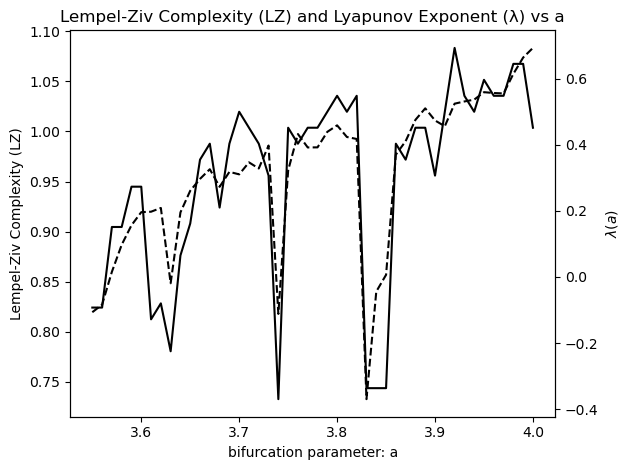

Pearson correlation between LZ and λ: 0.8945


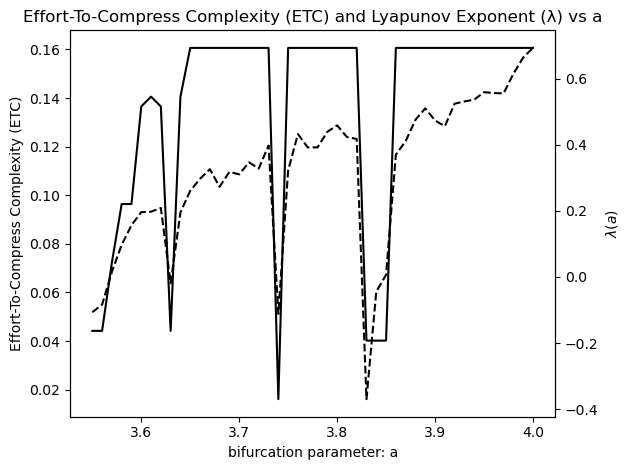

Pearson correlation between ETC and λ: 0.8751


In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Logistic map function
def logistic_map(a, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = a * x[i-1] * (1 - x[i-1])
    return x

# Symbolization with 4 bins
def symbolize(time_series, num_bins=4):
    min_val, max_val = np.min(time_series), np.max(time_series)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    return np.digitize(time_series, bin_edges[1:-1])

# Lempel-Ziv complexity calculation
def lz_complexity(symbolic_sequence):
    sub_strings = set()
    n = len(symbolic_sequence)
    ind = 0
    inc = 1
    while ind + inc <= n:
        sub_str = tuple(symbolic_sequence[ind:ind + inc])
        if sub_str in sub_strings:
            inc += 1
        else:
            sub_strings.add(sub_str)
            ind += inc
            inc = 1
    return len(sub_strings)

def normalized_lz_complexity(symbolic_sequence):
    n = len(symbolic_sequence)
    alpha = len(set(symbolic_sequence))
    if alpha <= 1:
        return 0.0
    c = lz_complexity(symbolic_sequence)
    return (c / n) * (np.log(n) / np.log(alpha))

# Effort-To-Compress complexity
def etc_complexity(symbolic_sequence, max_steps=40):
    sequence = list(symbolic_sequence)
    step = 0
    while len(set(sequence)) > 1 and len(sequence) > 2:
        pair_counts = Counter(zip(sequence[:-1], sequence[1:]))
        most_frequent_pair, _ = max(pair_counts.items(), key=lambda x: x[1])
        new_symbol = max(sequence) + 1
        
        # Replace non-overlapping pairs
        new_seq = []
        i = 0
        while i < len(sequence) - 1:
            if (sequence[i], sequence[i+1]) == most_frequent_pair:
                new_seq.append(new_symbol)
                i += 2
            else:
                new_seq.append(sequence[i])
                i += 1
        if i == len(sequence) - 1:
            new_seq.append(sequence[-1])
        
        # Check for changes
        if new_seq == sequence or len(new_seq) <= 2:
            break
        sequence = new_seq
        step += 1
        if max_steps and step >= max_steps:
            break
    return step

def normalized_etc_complexity(symbolic_sequence, max_steps=40):
    n = len(symbolic_sequence)
    etc = etc_complexity(symbolic_sequence, max_steps=max_steps)
    return etc / (n - 1) if n > 1 else 0.0

# Lyapunov exponent calculation
def lyapunov_logistic(a, x, n_discard=0):
    return np.mean(np.log(np.abs(a * (1 - 2 * x[n_discard:]))))

# Set parameters
a_values = np.arange(3.55, 4.01, 0.01)
n_points = 250  # Slightly increasing the length for smoother results
n_bins = 4
x0 = 0.5  # Initial condition

# Initialize arrays to store results
lyapunov_exponents = []
lz_complexities = []
etc_complexities = []

# Loop through each a value
for a in a_values:
    time_series = logistic_map(a, x0, n_points)
    symbolic_sequence = symbolize(time_series, num_bins=n_bins)
    
    # Lempel-Ziv complexity
    lz_comp = normalized_lz_complexity(symbolic_sequence)
    lz_complexities.append(lz_comp)
    
    # Effort-To-Compress complexity
    etc_comp = normalized_etc_complexity(symbolic_sequence, max_steps=40)
    etc_complexities.append(etc_comp)
    
    # Lyapunov exponent
    lyap_exp = lyapunov_logistic(a, time_series, n_discard=100)
    lyapunov_exponents.append(lyap_exp)

# Convert to numpy arrays
lyapunov_exponents = np.array(lyapunov_exponents)
lz_complexities = np.array(lz_complexities)
etc_complexities = np.array(etc_complexities)

# Plot LZ Complexity (LZ) and Lyapunov exponent (λ) for Figure 3
fig, ax1 = plt.subplots()
ax1.plot(a_values, lz_complexities, 'k-', label='LZ Complexity')
ax1.set_xlabel('bifurcation parameter: a')
ax1.set_ylabel('Lempel-Ziv Complexity (LZ)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(a_values, lyapunov_exponents, 'k--', label='Lyapunov Exponent (λ)')
ax2.set_ylabel(r'$\lambda(a)$', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Lempel-Ziv Complexity (LZ) and Lyapunov Exponent (λ) vs a')
fig.tight_layout()
plt.show()

# Pearson correlation for Figure 3
lz_corr = np.corrcoef(lz_complexities, lyapunov_exponents)[0, 1]
print(f"Pearson correlation between LZ and λ: {lz_corr:.4f}")

# Plot ETC Complexity (ETC) and Lyapunov exponent (λ) for Figure 4
fig, ax1 = plt.subplots()
ax1.plot(a_values, etc_complexities, 'k-', label='ETC Complexity')
ax1.set_xlabel('bifurcation parameter: a')
ax1.set_ylabel('Effort-To-Compress Complexity (ETC)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(a_values, lyapunov_exponents, 'k--', label='Lyapunov Exponent (λ)')
ax2.set_ylabel(r'$\lambda(a)$', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Effort-To-Compress Complexity (ETC) and Lyapunov Exponent (λ) vs a')
fig.tight_layout()
plt.show()

# Pearson correlation for Figure 4
etc_corr = np.corrcoef(etc_complexities, lyapunov_exponents)[0, 1]
print(f"Pearson correlation between ETC and λ: {etc_corr:.4f}")


# Table 1 - CCM vs. Shannon entropy

In [55]:
import numpy as np
from collections import Counter
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

# Logistic map function
def logistic_map(a, x0, n):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = a * x[i-1] * (1 - x[i-1])
    return x

# Hénon map function
def henon_map(a, b, n, x0=0.1, y0=0.1):
    x = np.zeros(n)
    y = np.zeros(n)
    x[0], y[0] = x0, y0
    for i in range(1, n):
        x[i] = 1 - a * x[i-1] ** 2 + y[i-1]
        y[i] = b * x[i-1]
    return x, y

# Lorenz system function
def lorenz_system(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Symbolization (quantizing to bins)
def symbolize(time_series, num_bins=4):
    min_val, max_val = np.min(time_series), np.max(time_series)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    return np.digitize(time_series, bin_edges[1:-1])

# Shannon entropy calculation
def calc_shannon_entropy(symbolic_sequence):
    counts = Counter(symbolic_sequence)
    probs = np.array(list(counts.values())) / len(symbolic_sequence)
    return -np.sum(probs * np.log2(probs)) if len(probs) > 1 else 0.0

# Lempel-Ziv complexity (LZ76 algorithm)
def lempel_ziv_complexity(sequence):
    i, k, l, c = 0, 1, 1, 1
    n = len(sequence)
    while l + k <= n:
        if sequence[i + k - 1] == sequence[l + k - 1]:
            k += 1
        else:
            i += 1
            if i == l:
                c += 1
                l += k
                k = 1
                i = 0
            else:
                k = 1
    return c

def normalized_lz_complexity(symbolic_sequence):
    n = len(symbolic_sequence)
    c = lempel_ziv_complexity(symbolic_sequence)
    return (c * np.log2(n)) / n if n > 1 else 0.0

# NSRPS-based Effort-to-Compress complexity
def nsrps_etc_complexity(sequence):
    sequence = list(sequence)
    step, symbol_counter = 0, max(sequence) + 1
    while len(sequence) > 1:
        pair_counts = Counter(zip(sequence[:-1], sequence[1:]))
        if not pair_counts: break
        most_frequent_pair, _ = pair_counts.most_common(1)[0]
        new_symbol = symbol_counter
        symbol_counter += 1
        new_sequence = []
        i = 0
        while i < len(sequence):
            if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == most_frequent_pair:
                new_sequence.append(new_symbol)
                i += 2
            else:
                new_sequence.append(sequence[i])
                i += 1
        sequence = new_sequence
        step += 1
    return step

def normalized_etc_complexity(symbolic_sequence):
    n = len(symbolic_sequence)
    etc = nsrps_etc_complexity(symbolic_sequence)
    return etc / (n - 1) if n > 1 else 0.0

# Function to analyze a chaotic system
def analyze_chaotic_system(system, params, length=500, num_bins=4):
    if system == 'logistic':
        a = params['a']
        time_series = logistic_map(a, 0.5, length)
    elif system == 'henon':
        a, b = params['a'], params['b']
        time_series, _ = henon_map(a, b, length)
    elif system == 'lorenz':
        sigma, rho, beta = params['sigma'], params['rho'], params['beta']
        t = np.linspace(0, 30, length)
        initial_state = [1.0, 1.0, 1.0]
        trajectory = odeint(lorenz_system, initial_state, t, args=(sigma, rho, beta))
        time_series = trajectory[:, 0]  # Use x-component of Lorenz system

    # Symbolize and calculate complexity measures
    symbolic_sequence = symbolize(time_series, num_bins=num_bins)
    H = calc_shannon_entropy(symbolic_sequence)
    LZ = normalized_lz_complexity(symbolic_sequence)
    ETC = normalized_etc_complexity(symbolic_sequence)
    return H, LZ, ETC

# Analyze each chaotic system with parameters from Table 1
systems = {
    'logistic': [{'a': 3.83}, {'a': 3.9}, {'a': 4.0}],
    'henon': [{'a': 1.2, 'b': 0.3}, {'a': 1.3, 'b': 0.3}, {'a': 1.4, 'b': 0.3}],
    'lorenz': [{'sigma': 10, 'rho': 20, 'beta': 8/3}, {'sigma': 10, 'rho': 25, 'beta': 8/3}, {'sigma': 10, 'rho': 28, 'beta': 8/3}]
}

results = []
for system, param_sets in systems.items():
    for params in param_sets:
        H, LZ, ETC = analyze_chaotic_system(system, params)
        results.append((system, params, H, LZ, ETC))

# Print results similar to Table 1
print(f"{'System':<10} {'Params':<30} {'H':<10} {'LZ':<10} {'ETC':<10}")
for result in results:
    system, params, H, LZ, ETC = result
    print(f"{system:<10} {str(params):<30} {H:<10.4f} {LZ:<10.4f} {ETC:<10.4f}")



System     Params                         H          LZ         ETC       
logistic   {'a': 3.83}                    1.5850     0.0538     0.0261    
logistic   {'a': 3.9}                     1.8979     8.7506     0.2104    
logistic   {'a': 4.0}                     0.0416     0.0538     0.0301    
henon      {'a': 1.2, 'b': 0.3}           1.8716     7.4057     0.1623    
henon      {'a': 1.3, 'b': 0.3}           1.9112     6.4374     0.1523    
henon      {'a': 1.4, 'b': 0.3}           1.9089     8.0333     0.2305    
lorenz     {'sigma': 10, 'rho': 20, 'beta': 2.6666666666666665} 0.3523     0.2510     0.0701    
lorenz     {'sigma': 10, 'rho': 25, 'beta': 2.6666666666666665} 1.6937     1.5780     0.1503    
lorenz     {'sigma': 10, 'rho': 28, 'beta': 2.6666666666666665} 1.7104     1.7214     0.1583    


# Table 2 - Logistic, Lorenz, Henon for H, LZ, ETC

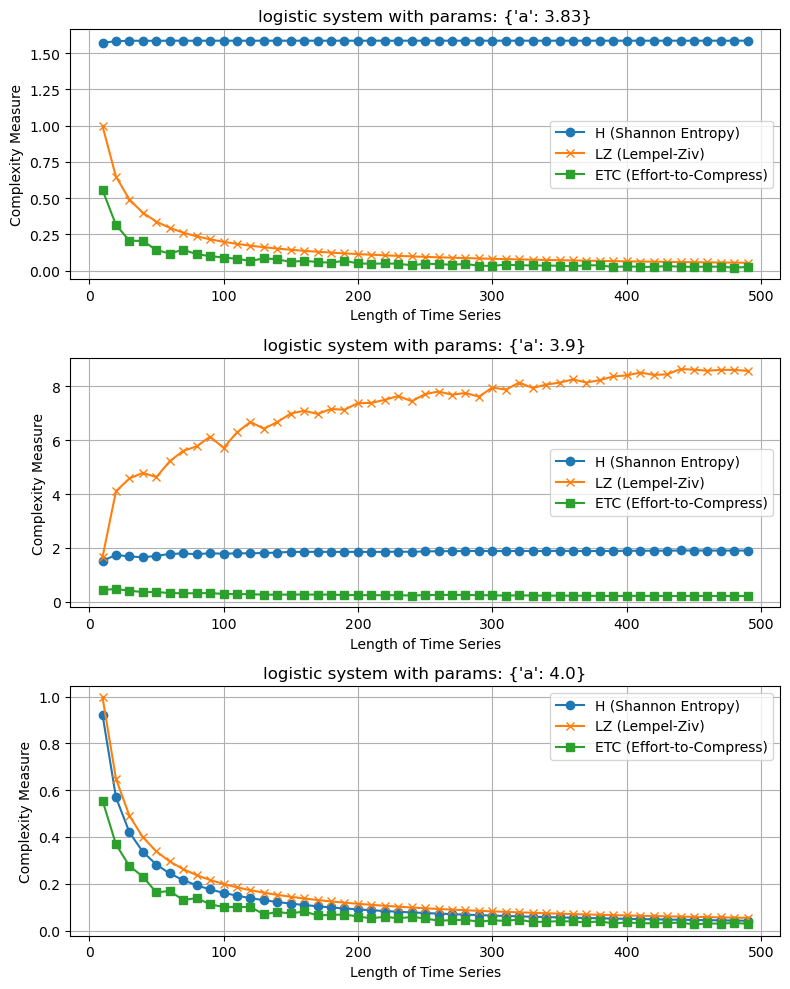

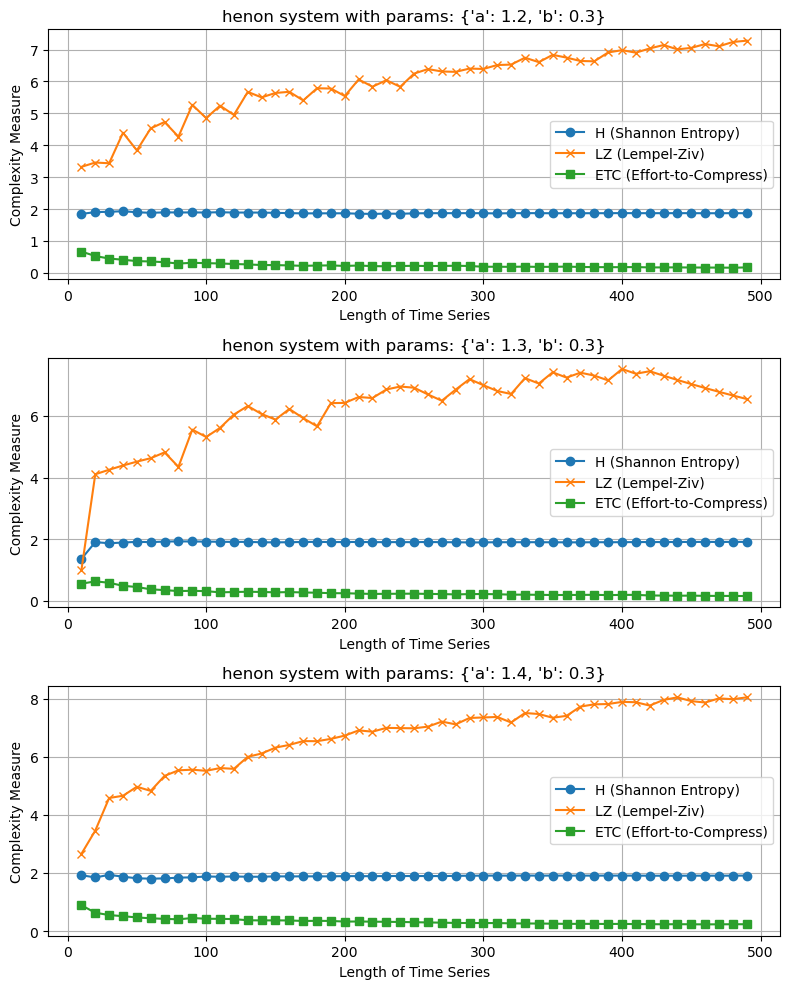

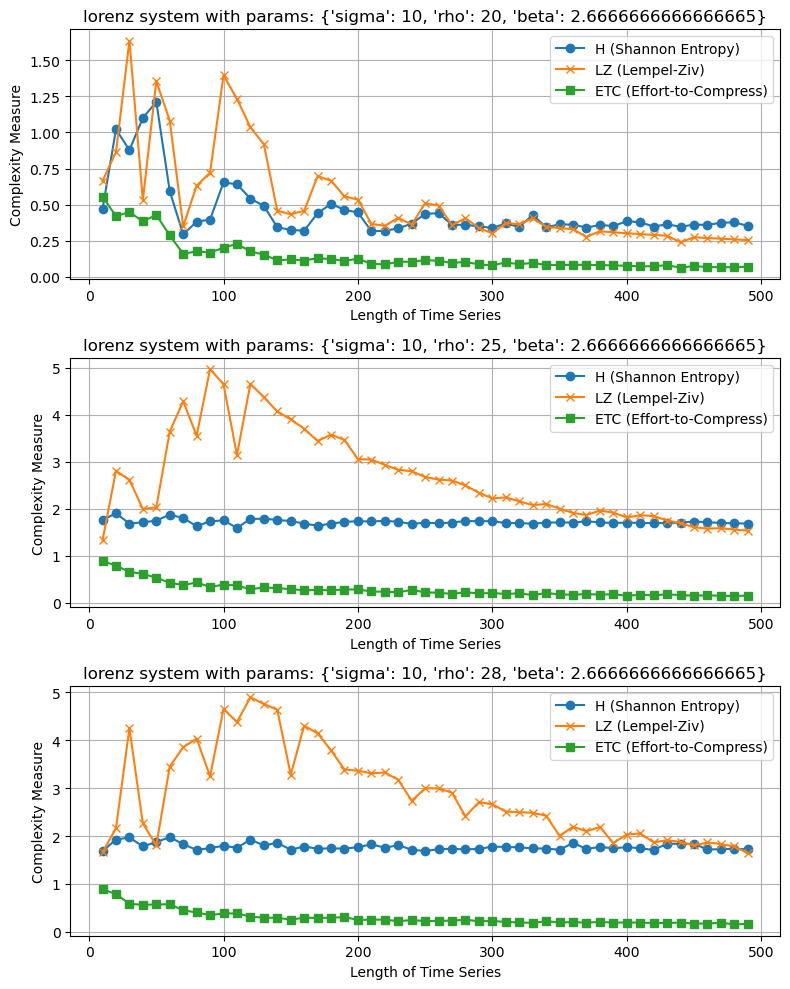

In [56]:
import numpy as np
from collections import Counter
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

# Define previously used functions (logistic_map, henon_map, lorenz_system, symbolize, etc.)

# Function to analyze chaotic systems for different lengths
def analyze_system_lengths(system, params, lengths, num_bins=4):
    correct_ordering = []
    
    for length in lengths:
        if system == 'logistic':
            a = params['a']
            time_series = logistic_map(a, 0.5, length)
        elif system == 'henon':
            a, b = params['a'], params['b']
            time_series, _ = henon_map(a, b, length)
        elif system == 'lorenz':
            sigma, rho, beta = params['sigma'], params['rho'], params['beta']
            t = np.linspace(0, 30, length)
            initial_state = [1.0, 1.0, 1.0]
            trajectory = odeint(lorenz_system, initial_state, t, args=(sigma, rho, beta))
            time_series = trajectory[:, 0]  # Use x-component of Lorenz system
        
        # Symbolize and compute complexity measures
        symbolic_sequence = symbolize(time_series, num_bins=num_bins)
        H = calc_shannon_entropy(symbolic_sequence)
        LZ = normalized_lz_complexity(symbolic_sequence)
        ETC = normalized_etc_complexity(symbolic_sequence)
        
        correct_ordering.append((H, LZ, ETC))
    
    return correct_ordering

# Parameters for each chaotic system
systems = {
    'logistic': [{'a': 3.83}, {'a': 3.9}, {'a': 4.0}],
    'henon': [{'a': 1.2, 'b': 0.3}, {'a': 1.3, 'b': 0.3}, {'a': 1.4, 'b': 0.3}],
    'lorenz': [{'sigma': 10, 'rho': 20, 'beta': 8/3}, {'sigma': 10, 'rho': 25, 'beta': 8/3}, {'sigma': 10, 'rho': 28, 'beta': 8/3}]
}

# Define the lengths to analyze
lengths = np.arange(10, 500, 10)

# Analyze systems for different lengths
results = {}
for system, param_sets in systems.items():
    system_results = []
    for params in param_sets:
        result = analyze_system_lengths(system, params, lengths)
        system_results.append(result)
    results[system] = system_results

# Plotting the results for each system
def plot_min_length_for_correct_order(results, system_name, param_sets, lengths):
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    for idx, param_set in enumerate(param_sets):
        system_results = results[system_name][idx]
        hs, lzs, etcs = [], [], []

        for result in system_results:
            hs.append(result[0])
            lzs.append(result[1])
            etcs.append(result[2])

        axs[idx].plot(lengths, hs, 'o-', label='H (Shannon Entropy)')
        axs[idx].plot(lengths, lzs, 'x-', label='LZ (Lempel-Ziv)')
        axs[idx].plot(lengths, etcs, 's-', label='ETC (Effort-to-Compress)')
        axs[idx].set_title(f"{system_name} system with params: {param_set}")
        axs[idx].set_xlabel("Length of Time Series")
        axs[idx].set_ylabel("Complexity Measure")
        axs[idx].legend()
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

# Plot for each system
plot_min_length_for_correct_order(results, 'logistic', systems['logistic'], lengths)
plot_min_length_for_correct_order(results, 'henon', systems['henon'], lengths)
plot_min_length_for_correct_order(results, 'lorenz', systems['lorenz'], lengths)

# Table 3 - Effect of Additive gaussian noise

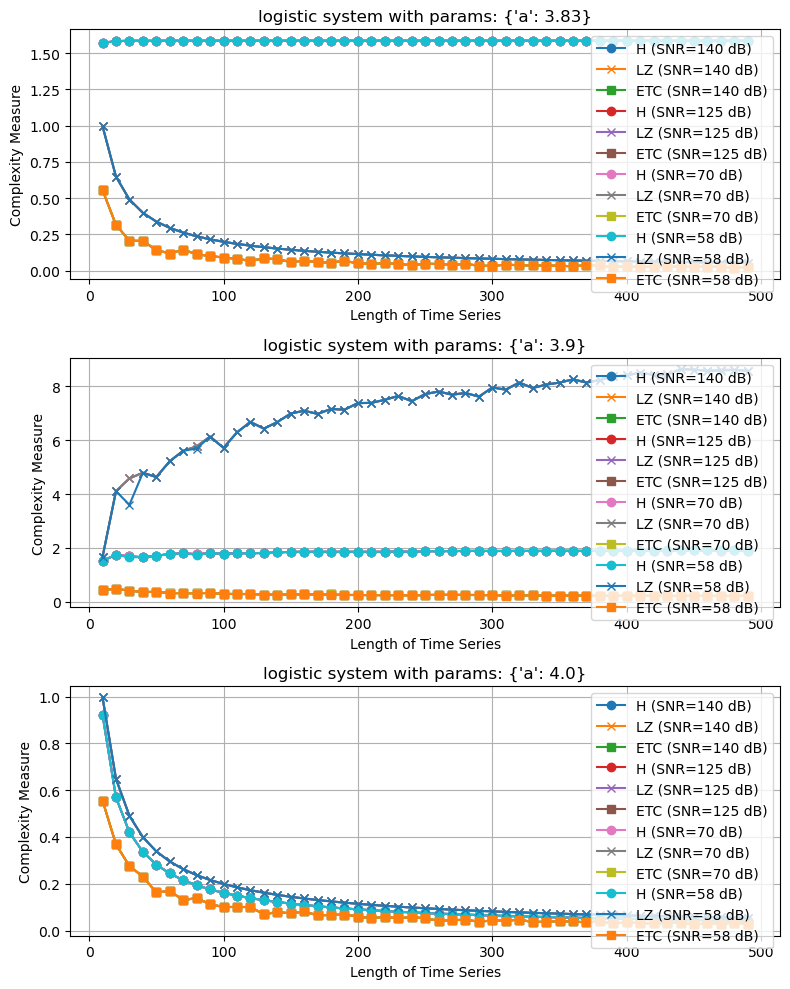

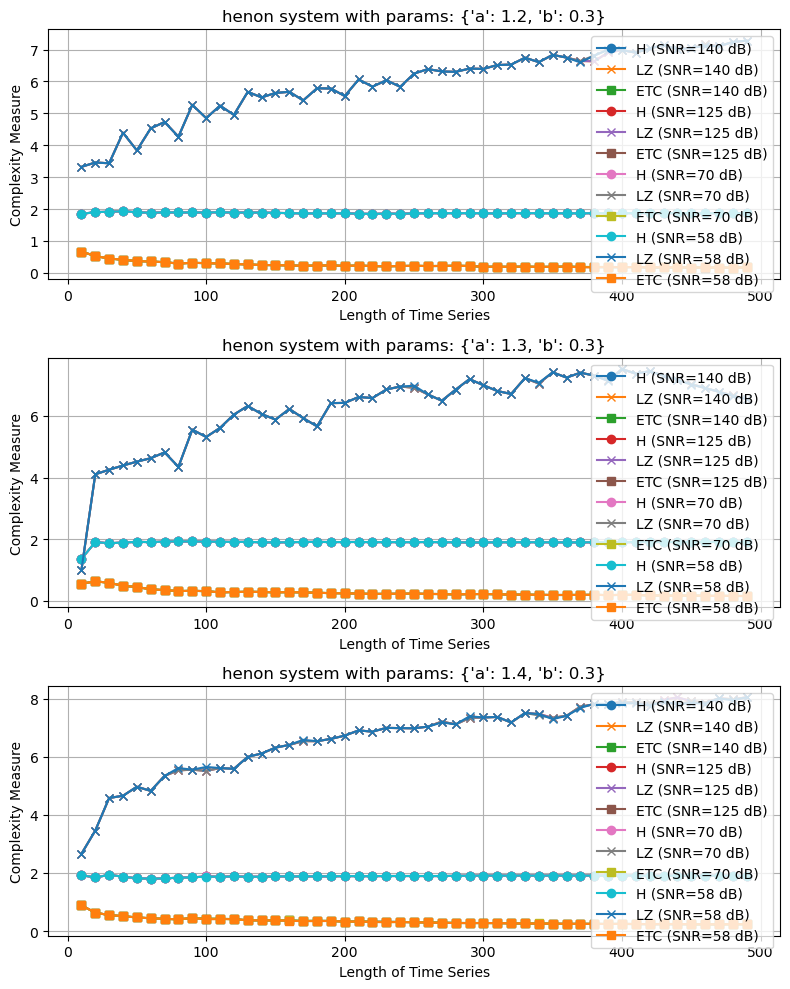

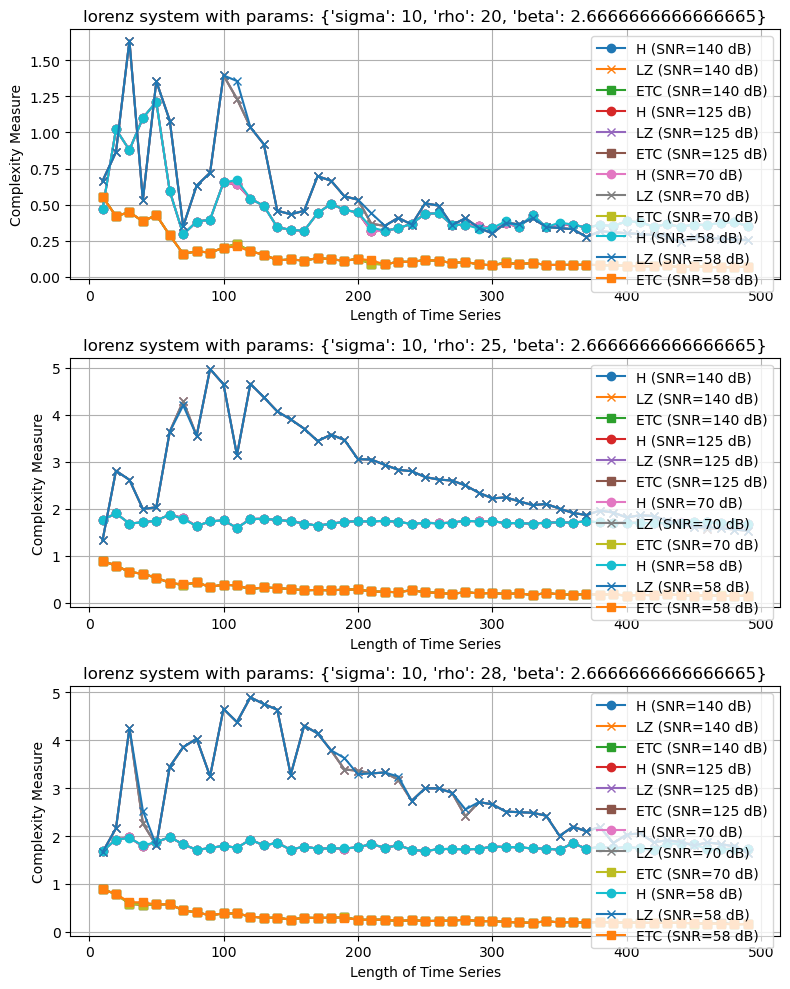

In [57]:
import numpy as np
from collections import Counter
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

# Define previously used functions for Logistic, Henon, Lorenz systems, calc_shannon_entropy, normalized_lz_complexity, normalized_etc_complexity

# Function to add Gaussian noise to a time series
def add_gaussian_noise(time_series, snr_db):
    signal_power = np.mean(np.square(time_series))
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(time_series))
    noisy_time_series = time_series + noise
    return noisy_time_series

# Function to analyze noisy time series for various SNR levels
def analyze_noisy_system(system, params, lengths, snr_levels, num_bins=4):
    snr_results = {}
    
    for snr_db in snr_levels:
        snr_results[snr_db] = []
        
        for length in lengths:
            if system == 'logistic':
                a = params['a']
                time_series = logistic_map(a, 0.5, length)
            elif system == 'henon':
                a, b = params['a'], params['b']
                time_series, _ = henon_map(a, b, length)
            elif system == 'lorenz':
                sigma, rho, beta = params['sigma'], params['rho'], params['beta']
                t = np.linspace(0, 30, length)
                initial_state = [1.0, 1.0, 1.0]
                trajectory = odeint(lorenz_system, initial_state, t, args=(sigma, rho, beta))
                time_series = trajectory[:, 0]  # Use x-component of Lorenz system
            
            # Add Gaussian noise to the time series
            noisy_time_series = add_gaussian_noise(time_series, snr_db)
            
            # Symbolize and compute complexity measures
            symbolic_sequence = symbolize(noisy_time_series, num_bins=num_bins)
            H = calc_shannon_entropy(symbolic_sequence)
            LZ = normalized_lz_complexity(symbolic_sequence)
            ETC = normalized_etc_complexity(symbolic_sequence)
            
            snr_results[snr_db].append((H, LZ, ETC))
    
    return snr_results

# Parameters for each chaotic system
systems = {
    'logistic': [{'a': 3.83}, {'a': 3.9}, {'a': 4.0}],
    'henon': [{'a': 1.2, 'b': 0.3}, {'a': 1.3, 'b': 0.3}, {'a': 1.4, 'b': 0.3}],
    'lorenz': [{'sigma': 10, 'rho': 20, 'beta': 8/3}, {'sigma': 10, 'rho': 25, 'beta': 8/3}, {'sigma': 10, 'rho': 28, 'beta': 8/3}]
}

# Define the lengths and SNR levels to analyze
lengths = np.arange(10, 500, 10)
snr_levels = [140, 125, 70, 58]  # SNR levels to analyze

# Analyze systems for different SNR levels and lengths
results_with_noise = {}
for system, param_sets in systems.items():
    system_results = []
    for params in param_sets:
        result = analyze_noisy_system(system, params, lengths, snr_levels)
        system_results.append(result)
    results_with_noise[system] = system_results

# Plotting the results for each system with noise
def plot_min_length_for_correct_order_with_noise(results, system_name, param_sets, snr_levels, lengths):
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    for idx, param_set in enumerate(param_sets):
        for snr_db in snr_levels:
            hs, lzs, etcs = [], [], []
            
            system_results = results[system_name][idx][snr_db]
            
            for result in system_results:
                hs.append(result[0])
                lzs.append(result[1])
                etcs.append(result[2])
            
            axs[idx].plot(lengths, hs, 'o-', label=f'H (SNR={snr_db} dB)')
            axs[idx].plot(lengths, lzs, 'x-', label=f'LZ (SNR={snr_db} dB)')
            axs[idx].plot(lengths, etcs, 's-', label=f'ETC (SNR={snr_db} dB)')
        
        axs[idx].set_title(f"{system_name} system with params: {param_set}")
        axs[idx].set_xlabel("Length of Time Series")
        axs[idx].set_ylabel("Complexity Measure")
        axs[idx].legend()
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

# Plot for each system
plot_min_length_for_correct_order_with_noise(results_with_noise, 'logistic', systems['logistic'], snr_levels, lengths)
plot_min_length_for_correct_order_with_noise(results_with_noise, 'henon', systems['henon'], snr_levels, lengths)
plot_min_length_for_correct_order_with_noise(results_with_noise, 'lorenz', systems['lorenz'], snr_levels, lengths)



# Table 4 - CCM vs. Shannon entropy on very short binary sequences

In [50]:
import numpy as np
from itertools import product
from collections import Counter
import math

# Shannon entropy calculation
def calc_shannon_entropy(symbolic_sequence):
    counts = Counter(symbolic_sequence)
    probs = np.array(list(counts.values())) / len(symbolic_sequence)
    return -np.sum(probs * np.log2(probs)) if len(probs) > 1 else 0.0

# Standard Lempel-Ziv complexity (LZ76 algorithm)
def lempel_ziv_complexity(sequence):
    i = 0
    k = 1
    l = 1
    n = len(sequence)
    c = 1
    while True:
        if sequence[i + k - 1] == sequence[l + k - 1]:
            k += 1
            if l + k > n:
                c += 1
                break
            elif i + k > l:
                i = 0
                l += 1
                k = 1
        else:
            i += 1
            if i == l:
                c += 1
                l += k
                if l + 1 > n:
                    break
                else:
                    i = 0
                    k = 1
    return c

def normalized_lz_complexity(symbolic_sequence):
    n = len(symbolic_sequence)
    c = lempel_ziv_complexity(symbolic_sequence)
    if n <= 1:
        return 0.0
    return (c * math.log2(n)) / n

# NSRPS-based Effort-to-Compress complexity
def nsrps_etc_complexity(sequence):
    sequence = list(sequence)
    step = 0
    symbol_counter = max(sequence) + 1  # New symbols will be assigned from this counter

    while len(sequence) > 1:
        # Count all overlapping pairs in the sequence
        pair_counts = Counter()
        for i in range(len(sequence) - 1):
            pair = (sequence[i], sequence[i + 1])
            pair_counts[pair] += 1
        if not pair_counts:
            break
        # Find the most frequent pair
        most_frequent_pair, _ = pair_counts.most_common(1)[0]
        new_symbol = symbol_counter
        symbol_counter += 1
        # Replace all overlapping occurrences of the most frequent pair
        i = 0
        new_sequence = []
        while i < len(sequence):
            if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == most_frequent_pair:
                new_sequence.append(new_symbol)
                i += 1  # Overlapping replacement allows next symbol to be part of another pair
            else:
                new_sequence.append(sequence[i])
            i += 1
        sequence = new_sequence
        step += 1
    return step

def normalized_etc_complexity(symbolic_sequence):
    n = len(symbolic_sequence)
    etc = nsrps_etc_complexity(symbolic_sequence)
    if n <= 1:
        return 0.0
    return etc / (n - 1)  # Normalized between 0 and 1

# Analyze short binary sequences for each length
def analyze_short_binary_sequences(min_length=4, max_length=16):
    results = {}

    for length in range(min_length, max_length + 1):
        sequences = [list(map(int, seq)) for seq in product([0, 1], repeat=length)]

        shannon_values = []
        lz_values = []
        etc_values = []

        for symbolic_seq in sequences:
            # Compute Shannon entropy
            shannon_values.append(calc_shannon_entropy(symbolic_seq))

            # Compute Lempel-Ziv complexity
            lz_values.append(normalized_lz_complexity(symbolic_seq))

            # Compute NSRPS-based ETC complexity
            etc_values.append(normalized_etc_complexity(symbolic_seq))

        # Store distinct values and means
        results[length] = {
            'H': {'distinct_values': len(set(shannon_values)), 'mean': np.mean(shannon_values)},
            'LZ': {'distinct_values': len(set(lz_values)), 'mean': np.mean(lz_values)},
            'ETC': {'distinct_values': len(set(etc_values)), 'mean': np.mean(etc_values)}
        }

    return results

# Print the results similar to Table 4
def print_results_table_4(results):
    print(f"{'Length':<8} {'H # distinct val.':<17} {'H Mean':<8} {'LZ # distinct val.':<17} {'LZ Mean':<9} {'ETC # distinct val.':<18} {'ETC Mean':<8}")
    for length, data in results.items():
        print(f"{length:<8} {data['H']['distinct_values']:<17} {data['H']['mean']:<8.4f} {data['LZ']['distinct_values']:<17} {data['LZ']['mean']:<9.4f} {data['ETC']['distinct_values']:<18} {data['ETC']['mean']:<.4f}")

# Run the analysis
results = analyze_short_binary_sequences()
print_results_table_4(results)


Length   H # distinct val. H Mean   LZ # distinct val. LZ Mean   ETC # distinct val. ETC Mean
4        3                 0.7806   2                 1.3750    2                  0.9167
5        3                 0.8324   2                 1.3351    2                  0.8594
6        4                 0.8648   3                 1.2925    3                  0.8000
7        4                 0.8867   3                 1.2408    3                  0.7786
8        5                 0.9024   3                 1.1895    4                  0.7478
9        5                 0.9143   3                 1.1392    4                  0.7207
10       6                 0.9235   4                 1.0913    5                  0.6957
11       6                 0.9309   4                 1.0461    4                  0.6788
12       7                 0.9370   4                 1.0036    6                  0.6620
13       7                 0.9421   4                 0.9639    6                  0.6460
14    

# Comparative of LZ and ETC on a two-state Markov process

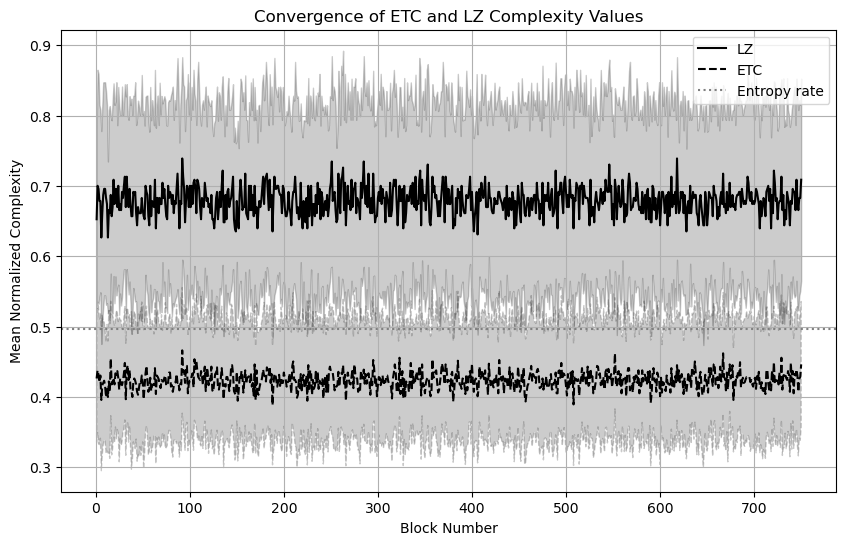

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Transition probabilities for the two-state Markov chain
P01 = 0.1
P10 = 0.8

# Generate two-state Markov chain
def two_state_markov_chain(p01, p10, n):
    states = [0]
    for _ in range(1, n):
        if states[-1] == 0:
            states.append(1 if np.random.random() < p01 else 0)
        else:
            states.append(0 if np.random.random() < p10 else 1)
    return states

# Lempel-Ziv complexity
def lempel_ziv_complexity(sequence):
    i = 0
    k = 1
    l = 1
    n = len(sequence)
    c = 1
    while True:
        if sequence[i + k - 1] == sequence[l + k - 1]:
            k += 1
            if l + k > n:
                c += 1
                break
            elif i + k > l:
                i = 0
                l += 1
                k = 1
        else:
            i += 1
            if i == l:
                c += 1
                l += k
                if l + 1 > n:
                    break
                else:
                    i = 0
                    k = 1
    return c

def normalized_lz_complexity(sequence):
    n = len(sequence)
    c = lempel_ziv_complexity(sequence)
    if n <= 1:
        return 0.0
    return (c * np.log2(n)) / n

# NSRPS-based Effort-to-Compress complexity
def nsrps_etc_complexity(sequence):
    sequence = list(sequence)
    step = 0
    symbol_counter = max(sequence) + 1

    while len(sequence) > 1:
        pair_counts = Counter(zip(sequence[:-1], sequence[1:]))
        if not pair_counts:
            break
        most_frequent_pair, _ = pair_counts.most_common(1)[0]
        new_symbol = symbol_counter
        symbol_counter += 1

        new_sequence = []
        i = 0
        while i < len(sequence):
            if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == most_frequent_pair:
                new_sequence.append(new_symbol)
                i += 2
            else:
                new_sequence.append(sequence[i])
                i += 1
        sequence = new_sequence
        step += 1
    return step

def normalized_etc_complexity(sequence):
    n = len(sequence)
    etc = nsrps_etc_complexity(sequence)
    return etc / (n - 1) if n > 1 else 0.0

# Entropy rate calculation for two-state Markov process
def entropy_rate_markov(p01, p10):
    mu0 = p10 / (p01 + p10)
    mu1 = p01 / (p01 + p10)
    return - (mu0 * (p01 * np.log2(p01) + (1 - p01) * np.log2(1 - p01)) +
              mu1 * (p10 * np.log2(p10) + (1 - p10) * np.log2(1 - p10)))

# Moving window analysis
def moving_window_analysis(data, measure_func, window_size=20):
    n = len(data)
    results = []

    for i in range(0, n - window_size + 1, window_size):
        window = data[i:i + window_size]
        results.append(measure_func(window))
    return results

# Compare complexity measures over iterations
def compare_complexity_measures(p01, p10, max_length, window_size=20, num_iterations=50):
    lz_results = []
    etc_results = []
    
    for _ in range(num_iterations):
        chain = two_state_markov_chain(p01, p10, max_length)
        
        # Use a list of integers instead of a string
        symbolic_chain = [0 if s == 0 else 1 for s in chain]
        
        lz_values = moving_window_analysis(symbolic_chain, normalized_lz_complexity, window_size)
        etc_values = moving_window_analysis(symbolic_chain, normalized_etc_complexity, window_size)
        
        lz_results.append(lz_values)
        etc_results.append(etc_values)
    
    lz_mean = np.mean(lz_results, axis=0)
    etc_mean = np.mean(etc_results, axis=0)
    lz_std = np.std(lz_results, axis=0)
    etc_std = np.std(etc_results, axis=0)
    
    return lz_mean, etc_mean, lz_std, etc_std

# Plot complexity comparison
def plot_complexity_comparison(lz_mean, etc_mean, lz_std, etc_std, entropy_rate):
    blocks = np.arange(1, len(lz_mean) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(blocks, lz_mean, label='LZ', color='black')
    plt.plot(blocks, etc_mean, label='ETC', color='black', linestyle='--')
    plt.axhline(y=entropy_rate, color='gray', linestyle=':', label='Entropy rate')
    
    plt.fill_between(blocks, lz_mean - lz_std, lz_mean + lz_std, alpha=0.2, color='black')
    plt.fill_between(blocks, etc_mean - etc_std, etc_mean + etc_std, alpha=0.2, color='black', linestyle='--')
    
    plt.xlabel('Block Number')
    plt.ylabel('Mean Normalized Complexity')
    plt.title('Convergence of ETC and LZ Complexity Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
p01, p10 = 0.1, 0.8
max_length = 15000
window_size = 20

entropy_rate = entropy_rate_markov(p01, p10)
lz_mean, etc_mean, lz_std, etc_std = compare_complexity_measures(p01, p10, max_length)

# Plot the result for Figure 6
plot_complexity_comparison(lz_mean, etc_mean, lz_std, etc_std, entropy_rate)


# Standard deviation of the complexity with data length

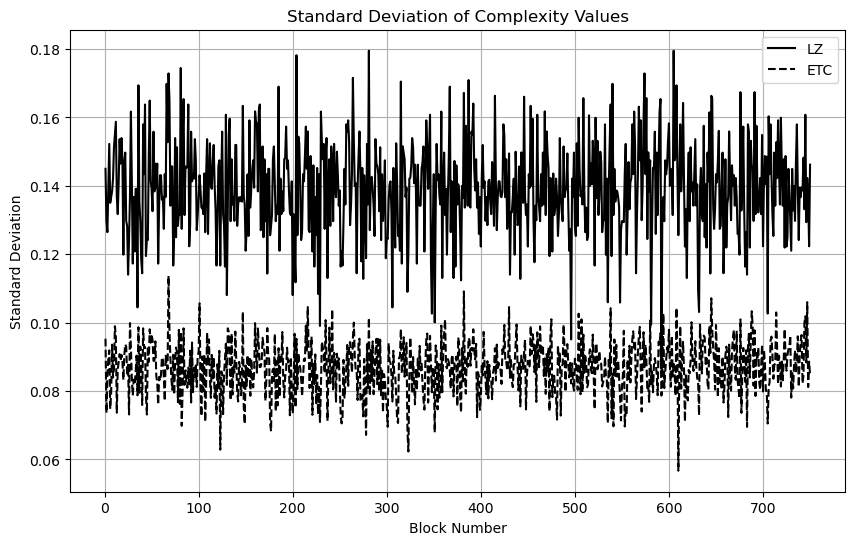

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Generate two-state Markov chain
def two_state_markov_chain(p01, p10, n):
    states = [0]
    for _ in range(1, n):
        if states[-1] == 0:
            states.append(1 if np.random.random() < p01 else 0)
        else:
            states.append(0 if np.random.random() < p10 else 1)
    return states

# Lempel-Ziv complexity
def lempel_ziv_complexity(sequence):
    i = 0
    k = 1
    l = 1
    n = len(sequence)
    c = 1
    while True:
        if sequence[i + k - 1] == sequence[l + k - 1]:
            k += 1
            if l + k > n:
                c += 1
                break
            elif i + k > l:
                i = 0
                l += 1
                k = 1
        else:
            i += 1
            if i == l:
                c += 1
                l += k
                if l + 1 > n:
                    break
                else:
                    i = 0
                    k = 1
    return c

def normalized_lz_complexity(sequence):
    n = len(sequence)
    c = lempel_ziv_complexity(sequence)
    if n <= 1:
        return 0.0
    return (c * np.log2(n)) / n

# NSRPS-based Effort-to-Compress complexity
def nsrps_etc_complexity(sequence):
    sequence = list(sequence)
    step = 0
    symbol_counter = max(sequence) + 1

    while len(sequence) > 1:
        pair_counts = Counter(zip(sequence[:-1], sequence[1:]))
        if not pair_counts:
            break
        most_frequent_pair, _ = pair_counts.most_common(1)[0]
        new_symbol = symbol_counter
        symbol_counter += 1

        new_sequence = []
        i = 0
        while i < len(sequence):
            if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == most_frequent_pair:
                new_sequence.append(new_symbol)
                i += 2
            else:
                new_sequence.append(sequence[i])
                i += 1
        sequence = new_sequence
        step += 1
    return step

def normalized_etc_complexity(sequence):
    n = len(sequence)
    etc = nsrps_etc_complexity(sequence)
    return etc / (n - 1) if n > 1 else 0.0

# Entropy rate calculation for two-state Markov process
def entropy_rate_markov(p01, p10):
    mu0 = p10 / (p01 + p10)
    mu1 = p01 / (p01 + p10)
    return - (mu0 * (p01 * np.log2(p01) + (1 - p01) * np.log2(1 - p01)) +
              mu1 * (p10 * np.log2(p10) + (1 - p10) * np.log2(1 - p10)))

# Moving window analysis
def moving_window_analysis(data, measure_func, window_size=20):
    n = len(data)
    results = []

    for i in range(0, n - window_size + 1, window_size):
        window = data[i:i + window_size]
        results.append(measure_func(window))
    return results

# Compare complexity measures over iterations
def compare_complexity_measures(p01, p10, max_length, window_size=20, num_iterations=50):
    lz_results = []
    etc_results = []
    
    for _ in range(num_iterations):
        chain = two_state_markov_chain(p01, p10, max_length)
        
        # Use a list of integers instead of a string
        symbolic_chain = [0 if s == 0 else 1 for s in chain]
        
        lz_values = moving_window_analysis(symbolic_chain, normalized_lz_complexity, window_size)
        etc_values = moving_window_analysis(symbolic_chain, normalized_etc_complexity, window_size)
        
        lz_results.append(lz_values)
        etc_results.append(etc_values)
    
    lz_mean = np.mean(lz_results, axis=0)
    etc_mean = np.mean(etc_results, axis=0)
    lz_std = np.std(lz_results, axis=0)
    etc_std = np.std(etc_results, axis=0)
    
    return lz_mean, etc_mean, lz_std, etc_std

# Plot complexity comparison (same as figure 6)
def plot_complexity_comparison(lz_mean, etc_mean, lz_std, etc_std, entropy_rate):
    blocks = np.arange(1, len(lz_mean) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(blocks, lz_mean, label='LZ', color='black')
    plt.plot(blocks, etc_mean, label='ETC', color='black', linestyle='--')
    plt.axhline(y=entropy_rate, color='gray', linestyle=':', label='Entropy rate')
    
    plt.fill_between(blocks, lz_mean - lz_std, lz_mean + lz_std, alpha=0.2, color='black')
    plt.fill_between(blocks, etc_mean - etc_std, etc_mean + etc_std, alpha=0.2, color='black', linestyle='--')
    
    plt.xlabel('Block Number')
    plt.ylabel('Mean Normalized Complexity')
    plt.title('Convergence of ETC and LZ Complexity Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot standard deviation for Figure 7
def plot_standard_deviation(lz_std, etc_std):
    blocks = np.arange(1, len(lz_std) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(blocks, lz_std, label='LZ', color='black')
    plt.plot(blocks, etc_std, label='ETC', color='black', linestyle='--')
    
    plt.xlabel('Block Number')
    plt.ylabel('Standard Deviation')
    plt.title('Standard Deviation of Complexity Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
p01, p10 = 0.1, 0.8
max_length = 15000
window_size = 20

entropy_rate = entropy_rate_markov(p01, p10)
lz_mean, etc_mean, lz_std, etc_std = compare_complexity_measures(p01, p10, max_length)

# Plot the result for Figure 7 (standard deviation plot)
plot_standard_deviation(lz_std, etc_std)
